In [59]:
#DATASET LINK
#https://github.com/megagonlabs/HappyDB

In [60]:
#LIBRARY 
import numpy as np 
import pandas as pd
import gensim
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
#RNN is good for sequence learning 

In [63]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cleaned_hm.csv")
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [64]:
#Do categories wise value count 
data['predicted_category'].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [65]:
# we have 7 difefrent class which designate cause of happiness 
#for a given happy moment we need to find the cause of happiness 



In [66]:
#remove the column with more number of sentence with less counts 
data['num_sentence'].value_counts()

1     83711
2      9542
3      3847
4      1624
5       821
6       336
7       183
8       107
10       68
9        61
11       35
13       26
12       21
16       17
18       17
14       14
17       14
19       12
21       10
25        7
15        7
23        7
24        5
26        5
22        4
29        3
31        3
30        3
20        3
27        2
32        2
37        2
40        2
56        1
46        1
53        1
51        1
48        1
69        1
35        1
45        1
44        1
42        1
58        1
34        1
28        1
60        1
Name: num_sentence, dtype: int64

In [67]:
# deleting happy moments with more than 10 sentences
mod_data = data.loc[data['num_sentence'] <= 10]
mod_data["predicted_category"].value_counts()

affection           34020
achievement         33966
enjoy_the_moment    11115
bonding             10700
leisure              7458
nature               1839
exercise             1202
Name: predicted_category, dtype: int64

In [68]:

## categorical to numerical
encode = {
    "affection" : 0,
    "achievement"  : 1,       
    "bonding" : 2,    
    "enjoy_the_moment" : 3,     
    "leisure"  : 4,    
    "nature" : 5,    
    "exercise" : 6
}
mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])
mod_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,0
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,0
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,6
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,0


In [69]:
#text cleaning for NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:

def clean_text(df):
    all_reviews = list()
    lines = df["cleaned_hm"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        #words=[ps.stem(word) for word in words_without_stop_words ]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews



In [71]:
happy_lines = clean_text(mod_data)
happy_lines[0:5]  

['i went on a successful date with someone i felt sympathy and connection with',
 'i was happy when my son got marks in his examination',
 'i went to the gym this morning and did yoga',
 'we had a serious talk with some friends of ours who have been flaky lately they understood and we had a good evening hanging out',
 'i went with grandchildren to butterfly display at crohn conservatory']

In [72]:
print("Now we have no of happy moments as features :",len(happy_lines))
print("Number of target label", len(mod_data['predicted_category']))

Now we have no of happy moments as features : 100300
Number of target label 100300


In [73]:
#here we can see every lines have different length 
#to process the same in neural network we need to do below 3 things 

#a.represent text in numerical format 
#b.make all setence of fixed length to process in neural network if not present than pad 0 pre or post 
#c.

In [74]:
#number of words in each review/ happymoments/sentence=55
validation_split = 0.2
max_length = 55
#tokenize te sentences and represent them in numbers other way is to todo one hot 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)
sequences

[[1, 23, 16, 3, 726, 302, 13, 283, 1, 90, 9711, 5, 2149, 13],
 [1, 7, 15, 22, 2, 68, 17, 1028, 9, 67, 1532],
 [1, 23, 4, 6, 394, 33, 98, 5, 152, 1021],
 [21,
  18,
  3,
  1773,
  320,
  13,
  41,
  50,
  11,
  3798,
  123,
  36,
  53,
  14710,
  1064,
  80,
  2534,
  5,
  21,
  18,
  3,
  40,
  310,
  969,
  28],
 [1, 23, 13, 1992, 4, 4330, 3898, 19, 14711, 14712],
 [1, 3561, 38, 71],
 [1, 20, 3, 27, 728, 8, 11437, 1316, 5, 14, 81, 28, 5902],
 [1, 17, 216, 29, 2, 2177, 166, 65, 7, 45, 2056, 10],
 [64, 2, 3036, 84, 31, 1, 140],
 [164, 3562, 2105, 13, 2, 241, 4654, 360],
 [1, 81, 9, 1592, 232, 9, 2, 329, 11, 2535, 209, 103],
 [1, 261, 2, 819, 379, 236, 526, 14, 195, 10, 104, 1689],
 [23, 4, 580, 13, 2, 50, 14, 7, 160],
 [1, 7, 14713, 1227, 5, 20, 29, 6, 1849],
 [745,
  987,
  14,
  125,
  61,
  1204,
  2715,
  4,
  91,
  29,
  2178,
  4,
  15,
  31,
  130,
  514,
  97,
  277,
  8,
  6,
  268,
  12,
  5578,
  130,
  28,
  11,
  292,
  2178,
  224,
  5,
  3899,
  130,
  9,
  6,
  2269,
  1

In [75]:
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

unique tokens - 23773
vocab_size - 23774


In [76]:
#get first 10 elements word_index
dict_items = word_index.items()
first_ten = list(dict_items)[:10]
print(first_ten)

[('i', 1), ('my', 2), ('a', 3), ('to', 4), ('and', 5), ('the', 6), ('was', 7), ('for', 8), ('in', 9), ('me', 10)]


In [77]:
#do padding 
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
lines_pad

array([[   1,   23,   16, ...,    0,    0,    0],
       [   1,    7,   15, ...,    0,    0,    0],
       [   1,   23,    4, ...,    0,    0,    0],
       ...,
       [1841,   13,    2, ...,    0,    0,    0],
       [   1,   18,    3, ...,    0,    0,    0],
       [   1,   18,    3, ...,    0,    0,    0]], dtype=int32)

In [78]:
print("Now we have no of happy moments as features :",len(lines_pad))
print("Number of target label", len(mod_data['predicted_category']))

Now we have no of happy moments as features : 100300
Number of target label 100300


In [79]:
X=lines_pad
y=pd.get_dummies(mod_data['predicted_category']).values
#Y = pd.get_dummies(df['Product']).values
type(y)

numpy.ndarray

In [80]:
#train test Split :
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (80240, 55)
Shape of y_train: (80240, 7)
Shape of X_test_pad: (20060, 55)
Shape of y_test: (20060, 7)


#NOW WE WILL DO WORD2 VEC USING TRAINED MODEL GoogleNews-vectors-negative300

In [81]:
word_index 

{'i': 1,
 'my': 2,
 'a': 3,
 'to': 4,
 'and': 5,
 'the': 6,
 'was': 7,
 'for': 8,
 'in': 9,
 'me': 10,
 'of': 11,
 'that': 12,
 'with': 13,
 'it': 14,
 'happy': 15,
 'on': 16,
 'got': 17,
 'had': 18,
 'at': 19,
 'made': 20,
 'we': 21,
 'when': 22,
 'went': 23,
 'time': 24,
 'is': 25,
 'very': 26,
 'new': 27,
 'out': 28,
 'from': 29,
 'day': 30,
 'so': 31,
 'work': 32,
 'this': 33,
 'an': 34,
 's': 35,
 'have': 36,
 'her': 37,
 'last': 38,
 'friend': 39,
 'good': 40,
 'some': 41,
 'up': 42,
 'he': 43,
 'after': 44,
 'really': 45,
 'she': 46,
 'able': 47,
 'today': 48,
 'one': 49,
 'friends': 50,
 'all': 51,
 'family': 52,
 'been': 53,
 'first': 54,
 't': 55,
 'about': 56,
 'our': 57,
 'am': 58,
 'home': 59,
 'as': 60,
 'be': 61,
 'get': 62,
 'found': 63,
 'yesterday': 64,
 'which': 65,
 'but': 66,
 'his': 67,
 'son': 68,
 'great': 69,
 'dinner': 70,
 'night': 71,
 'not': 72,
 'long': 73,
 'because': 74,
 'finally': 75,
 'see': 76,
 'daughter': 77,
 'by': 78,
 'job': 79,
 'they': 80,
 'c

In [82]:
#we will use google word2vec pretrained model 
#here we dont need to train embedding layer as it is already trained we just need to fit that model to
#our requirement for better prediction 

In [83]:

import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [84]:
#FIRST WE WILL CREATE EMBEDDING LAYER 

In [85]:
#EMBEDDING LAYER ROWS = NUMBER OF WORDS IN CORPUS 
#EMBEDDING LAYER COLUMNS = 300 as the google word vector we have taken comntains 300 columns 
#basically embedding layer represent weight matrix between input layer and hidden layer 


In [86]:
embedding_dim=300
#make a  matrix of zeros with rows = numner of words and columns =300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#if the word is not present in model that we have impoeted then that word vector will be replaced in
#embedding matrix otherwise it will remain 0 as we have defined 

for word, i in word_index.items():
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector

In [87]:
#create embedding layer 
#Embedding layer takes input as dimension  i.e number of rows , column =300 ]
#weights wil be the weight matrix as defined above 
#we will make trainable = false as weight matrix is trained already 
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [88]:
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec.add(Dense(7, activation='softmax'))

model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 300)           7132200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 7,175,055
Trainable params: 42,855
Non-trainable params: 7,132,200
_________________________________________________________________
None


In [89]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

In [90]:
history_word2vec = model_word2vec.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Train on 80240 samples, validate on 20060 samples
Epoch 1/10
80240/80240 [==============================] - 208s 3ms/step - loss: 1.3931 - accuracy: 0.4713 - val_loss: 1.0168 - val_accuracy: 0.6328
Epoch 2/10
80240/80240 [==============================] - 207s 3ms/step - loss: 0.8432 - accuracy: 0.7155 - val_loss: 0.5987 - val_accuracy: 0.8125
Epoch 3/10
80240/80240 [==============================] - 206s 3ms/step - loss: 0.5822 - accuracy: 0.8113 - val_loss: 0.4975 - val_accuracy: 0.8318
Epoch 4/10
80240/80240 [==============================] - 206s 3ms/step - loss: 0.4996 - accuracy: 0.8301 - val_loss: 0.4233 - val_accuracy: 0.8477
Epoch 5/10
80240/80240 [==============================] - 205s 3ms/step - loss: 0.4378 - accuracy: 0.8452 - val_loss: 0.3934 - val_accuracy: 0.8567
Epoch 6/10
80240/80240 [==============================] - 206s 3ms/step - loss: 0.4049 - accuracy: 0.8547 - val_loss: 0.3656 - val_accuracy: 0.8656
Epoch 7/10
80240/80240 [==============================] - 205s

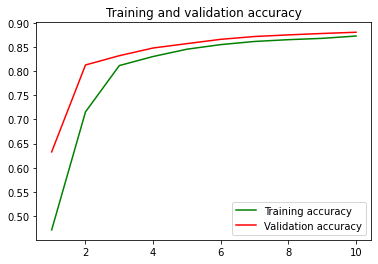

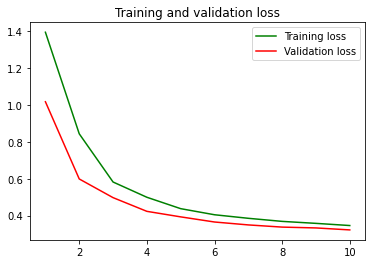

In [91]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['accuracy']
val_acc = history_word2vec.history['val_accuracy']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [92]:

#y_pred=model_word2vec.predict_classes(X_test)
accr = model_word2vec.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20060/20060 [==============================] - 12s 622us/step
Test set
  Loss: 0.323
  Accuracy: 0.880


In [99]:
#TEST With a new emotion for classification 
max_length = 55 #this is already defined on top
new_emotion = ['I went to the gym this morning and did yoga ']
seq = tokenizer_obj.texts_to_sequences(new_emotion)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_word2vec.predict(padded)
labels = ['affection','achievement','enjoy_the_moment','bonding','leisure','nature','exercise']
print(pred, labels[np.argmax(pred)])

[[0.03566507 0.24813165 0.00621534 0.05729232 0.05029689 0.07905859
  0.52334017]] exercise


In [94]:
pred

array([[0.07720961, 0.59572256, 0.03077719, 0.10171159, 0.08249336,
        0.01992638, 0.09215925]], dtype=float32)